# Prepare Environment

In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
from collections import Counter
import os

from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras import layers

import datetime
import time




Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
import keras
keras.__version__

'3.4.1'

In [ ]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Seed 1
#np.random.seed(1234)
#tf.random.set_seed(5678)

# Seed 2
#np.random.seed(123)
#tf.random.set_seed(5667)

# Seed 3
#np.random.seed(99)
#tf.random.set_seed(100)

# Import Data and Pre-processing

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Firstly, import the image. The image will originally be 256 pixels in size.

In [ ]:
batch_size = 16
CROP_LENGTH = 224


In [ ]:
# Path ของโฟลเดอร์ชุดข้อมูลใน Google Drive
dataset_dir = '/content/drive/MyDrive/DADS_Deep Learning/Final_Project/Picture'  # แทนที่ด้วย path ของชุดข้อมูลใน Google Drive


def load_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        shuffle=True
    )

    class_names = dataset.class_names

    images = []
    labels = []
    for batch, label in dataset:
        images.append(batch.numpy())
        labels.append(label.numpy())

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels, class_names

def count_images_per_class(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = {class_names[i]: counts[i] for i in unique}
    return class_counts

# Load datasets
x_train, y_train, train_class_names = load_dataset(os.path.join(dataset_dir, 'Train'))
x_val, y_val, val_class_names = load_dataset(os.path.join(dataset_dir, 'Valid'))
x_test, y_test, test_class_names = load_dataset(os.path.join(dataset_dir, 'Test'))

# Verify dataset shapes
print(f'Training data shape: {x_train.shape}, {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, {y_val.shape}')
print(f'Test data shape: {x_test.shape}, {y_test.shape}')

# Count images per class
train_class_counts = count_images_per_class(y_train, train_class_names)
val_class_counts = count_images_per_class(y_val, val_class_names)
test_class_counts = count_images_per_class(y_test, test_class_names)

# Display class counts
print('Training data class counts:', train_class_counts)
print('Validation data class counts:', val_class_counts)
print('Test data class counts:', test_class_counts)

Found 828 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Training data shape: (828, 256, 256, 3), (828,)
Validation data shape: (177, 256, 256, 3), (177,)
Test data shape: (177, 256, 256, 3), (177,)
Training data class counts: {'damage': 578, 'good': 250}
Validation data class counts: {'damage': 123, 'good': 54}
Test data class counts: {'damage': 123, 'good': 54}


Plot images after loading dataset

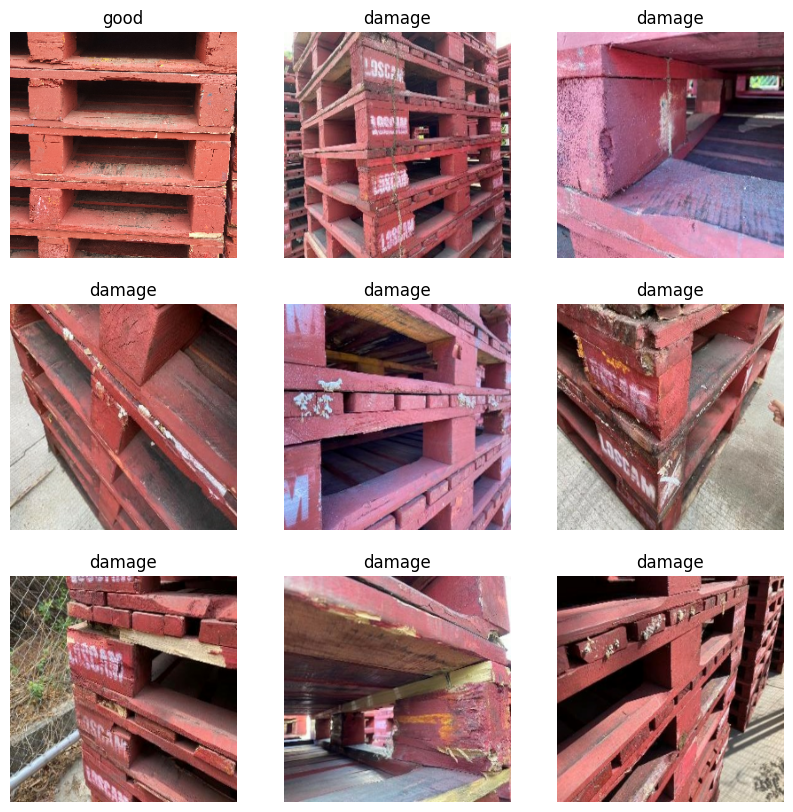

In [ ]:
def plot_random_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_images, replace=False)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.show()


# Plot a sample of images
plot_random_images(x_train, y_train, train_class_names, num_images=9)

## Ramdom Crop from 256 to 224

In [ ]:
CROP_LENGTH = 224
# Apply Random Cropping

# Function to apply random cropping
def random_crop(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

# Apply random cropping to the entire dataset
def apply_random_cropping(images, labels, crop_length):
    cropped_images = np.zeros((images.shape[0], crop_length, crop_length, 3))
    for i in range(images.shape[0]):
        cropped_images[i] = random_crop(images[i], (crop_length, crop_length))
    return cropped_images, labels


# Apply random cropping
x_train_cropped, y_train_cropped = apply_random_cropping(x_train, y_train, CROP_LENGTH)
x_val_cropped, y_val_cropped = apply_random_cropping(x_val, y_val, CROP_LENGTH)
x_test_cropped, y_test_cropped = apply_random_cropping(x_test, y_test, CROP_LENGTH)

# Print shapes of cropped datasets
print(f'Training data shape after cropping: {x_train_cropped.shape}')
print(f'Training labels shape: {y_train_cropped.shape}')
print(f'Validation data shape after cropping: {x_val_cropped.shape}')
print(f'Validation labels shape: {y_val_cropped.shape}')
print(f'Test data shape after cropping: {x_test_cropped.shape}')
print(f'Test labels shape: {y_test_cropped.shape}')

Training data shape after cropping: (828, 224, 224, 3)
Training labels shape: (828,)
Validation data shape after cropping: (177, 224, 224, 3)
Validation labels shape: (177,)
Test data shape after cropping: (177, 224, 224, 3)
Test labels shape: (177,)


## Rescale and Augmentation

In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', name='rand_trans')
])

In [ ]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create a tf.data.Dataset from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((x_train_cropped, y_train_cropped))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_cropped, y_val_cropped))
test_ds = tf.data.Dataset.from_tensor_slices((x_test_cropped, y_test_cropped))


In [ ]:
#Apply augmentation and rescale
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

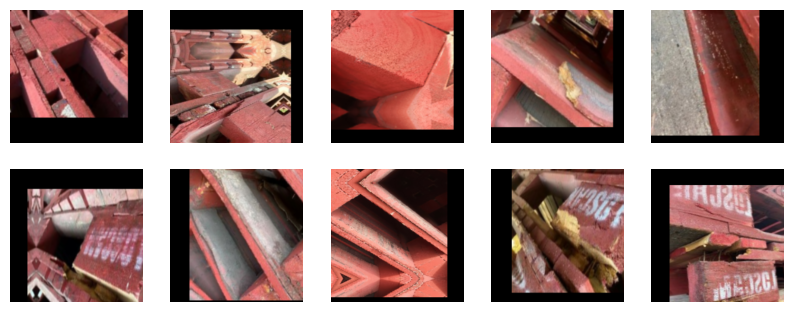

In [ ]:
# Function to plot images after applying augmentation
def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")

# Plot random images from train_ds
plot_images(train_ds, num_images=10)
plt.show()

In [ ]:
# Function to check image size in train_ds
def check_image_size(dataset):
    for images, _ in dataset.take(1):  # Take the first batch
        print(f"Training Image shape: {images.shape}")

# Check the size of the images
check_image_size(train_ds)


Training Image shape: (16, 224, 224, 3)


In [ ]:
# Function to count total number of images train_ds
def count_images(dataset):
    total_images = 0
    for images, _ in dataset:
        batch_size = images.shape[0]
        total_images += batch_size
    return total_images

# Count the total number of images
total_images = count_images(train_ds)
print(f"Total number of images in train dataset: {total_images}")

Total number of images in train dataset: 828


## Over Sampling

In [ ]:
# Function to convert dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []

    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return images_array, labels_array

# Convert train_ds to NumPy arrays
x_train_np, y_train_np = dataset_to_numpy(train_ds)

print("x_ train Images shape:", x_train_np.shape)
print("y_ train shape:", y_train_np.shape)

# Convert val_ds to NumPy arrays
x_val_np, y_val_np = dataset_to_numpy(val_ds)

print("x_ val Images shape:", x_val_np.shape)
print("y_ val shape:", y_val_np.shape)

# Convert test_ds to NumPy arrays
x_test_np, y_test_np = dataset_to_numpy(test_ds)

print("x_ test Images shape:", x_test_np.shape)
print("y_ test shape:", y_test_np.shape)

x_ train Images shape: (828, 224, 224, 3)
y_ train shape: (828,)
x_ val Images shape: (177, 224, 224, 3)
y_ val shape: (177,)
x_ test Images shape: (177, 224, 224, 3)
y_ test shape: (177,)


In [ ]:
# Apply RandomOverSampler to training set data
def apply_random_oversampling(images, labels):
    ros = RandomOverSampler(random_state=42)
    # Reshape images to 2D (samples, features) for the oversampler
    num_samples = images.shape[0]
    image_flattened = images.reshape(num_samples, -1)

    # Apply oversampling
    X_resampled, y_resampled = ros.fit_resample(image_flattened, labels)

    # Reshape images back to original shape
    images_resampled = X_resampled.reshape(-1, *images.shape[1:])

    return images_resampled, y_resampled

# Apply oversampling to NumPy arrays
oversampled_x_train, oversampled_y_train = apply_random_oversampling(x_train_np, y_train_np)

In [ ]:
print(oversampled_x_train.shape)

(1156, 224, 224, 3)


In [ ]:
# Summary number of data after applying over sampling
# Define class names
class_names = {
    0: 'damage',
    1: 'good',
}

# Function to count images per class and map labels to class names
def count_images_per_class(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_name_counts = {class_names.get(label, str(label)): count for label, count in zip(unique_labels, counts)}
    return label_name_counts

# Count images per class in the oversampled dataset
class_counts = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class after oversampling:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Image counts per class after oversampling:
damage: 578 images
good: 578 images


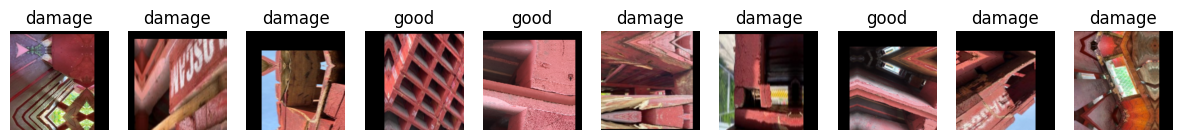

In [ ]:
# Function to plot images after over sampling
def plot_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 10))

    # Randomly sample images to plot
    indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names.get(labels[idx], str(labels[idx])))
        plt.axis('off')

    plt.show()

# Plot a subset of images from the oversampled dataset
plot_images(oversampled_x_train, oversampled_y_train, class_names)

## Summary data set to train the models **

In [ ]:
#1. Training Data
#  - Use oversampled_x_train, oversampled_y_train (NumPy arrays)
print(f'Training data shape: {oversampled_x_train.shape}, {oversampled_y_train.shape}')
# Count images per class in the oversampled dataset
class_counts_train = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class of training set:")
for class_name, count in class_counts_train.items():
    print(f"{class_name}: {count} images")

print('\n')

#2. Validation Data
#  - Use x_val_np, y_val_np  (NumPy arrays)
print(f'Validation data shape: {x_val_np.shape}, {y_val_np.shape}')
# Count images per class
class_counts_val = count_images_per_class(y_val_np)

# Print class counts
print("Image counts per class of validation set:")
for class_name, count in class_counts_val.items():
    print(f"{class_name}: {count} images")

print('\n')

#3. Test Data
#  - Use x_test_np, y_test_np  (NumPy arrays)
print(f'Test data shape: {x_test_np.shape}, {y_test_np.shape}')
# Count images per class
class_counts_test = count_images_per_class(y_test_np)

# Print class counts
print("Image counts per class of test set:")
for class_name, count in class_counts_test.items():
    print(f"{class_name}: {count} images")



Training data shape: (1156, 224, 224, 3), (1156,)
Image counts per class of training set:
damage: 578 images
good: 578 images


Validation data shape: (177, 224, 224, 3), (177,)
Image counts per class of validation set:
damage: 123 images
good: 54 images


Test data shape: (177, 224, 224, 3), (177,)
Image counts per class of test set:
damage: 123 images
good: 54 images


# Model Development

## Load feature extractor and construct the model

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-large-patch16-224")
model = TFViTModel.from_pretrained("google/vit-large-patch16-224")

model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


tf_model.h5:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some layers from the model checkpoint at google/vit-large-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  304351232 
                                                                 
Total params: 304351232 (1.13 GB)
Trainable params: 304351232 (1.13 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf

batch_size = 16  # Adjust this value based on your GPU memory

# Iterate over your data in batches
for i in range(0, oversampled_x_train.shape[0], batch_size):
    batch_inputs = image_processor(oversampled_x_train[i:i+batch_size], return_tensors="tf")
    batch_outputs = model(**batch_inputs)

    # Process the outputs for this batch (e.g., extract last hidden states)
    batch_last_hidden_states = batch_outputs.last_hidden_state
    print(list(batch_last_hidden_states.shape))

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197, 1024]
[16, 197

In [ ]:
# Freeze all layers in the feature extractor
model.trainable = False
model.summary()

Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  304351232 
                                                                 
Total params: 304351232 (1.13 GB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 304351232 (1.13 GB)
_________________________________________________________________


In [ ]:
# An input layer
img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
#cls_outputs_m2 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m2')(vit_features[:, 0, :])

# Construct the model
#model2 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m2])
#model2.summary()

## Prepare data for model

In [ ]:
# Change images from channel-last (default of Keras and TensorFlow) to channel-first (required by Huggingface's ViT)
x_train2 = np.moveaxis(oversampled_x_train, -1, 1)
x_test2 = np.moveaxis(x_test_np, -1, 1)
x_val2 = np.moveaxis(x_val_np, -1, 1)

# Inspect the dataset
print( f"x_train2: type={type(x_train2)} , dtype={x_train2.dtype} , shape={x_train2.shape} , min={x_train2.min(axis=None)} , max={x_train2.max(axis=None)}" )
print( f"x_test2: type={type(x_test2)} , dtype={x_test2.dtype} , shape={x_test2.shape} , min={x_test2.min(axis=None)} , max={x_test2.max(axis=None)}"  )

x_train2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=0.0 , max=1.0
x_test2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=0.0 , max=1.0


In [ ]:
x_train_vit = np.array( image_processor(x_train2,do_rescale = False)['pixel_values'] )
y_train_vit = oversampled_y_train
x_test_vit = np.array( image_processor(x_test2,do_rescale = False)['pixel_values'] )
y_test_vit = y_test_np
x_val_vit = np.array( image_processor(x_val2,do_rescale = False)['pixel_values'] )
y_val_vit = y_val_np

# Inspect the dataset
print( f"x_train_vit: type={type(x_train_vit)} , dtype={x_train_vit.dtype} , shape={x_train_vit.shape} , min={x_train_vit.min(axis=None)} , max={x_train_vit.max(axis=None)}" )
print( f"y_train_vit: type={type(y_train_vit)} , dtype={y_train_vit.dtype} , shape={y_train_vit.shape} , min={min(y_train_vit)} , max={max(y_train_vit)}" )
print( f"x_test_vit: type={type(x_test_vit)} , dtype={x_test_vit.dtype} , shape={x_test_vit.shape} , min={x_test_vit.min(axis=None)} , max={x_test_vit.max(axis=None)}"  )
print( f"y_test_vit: type={type(y_test_vit)} , dtype={y_test_vit.dtype} , shape={y_test_vit.shape} , min={min(y_test_vit)} , max={max(y_test_vit)}" )
print( f"x_val_vit: type={type(x_val_vit)} , dtype={x_val_vit.dtype} , shape={x_val_vit.shape} , min={x_val_vit.min(axis=None)} , max={x_val_vit.max(axis=None)}"  )
print( f"y_val_vit: type={type(y_val_vit)} , dtype={y_val_vit.dtype} , shape={y_val_vit.shape} , min={min(y_val_vit)} , max={max(y_val_vit)}" )

x_train_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=-1.0 , max=1.0
y_train_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(1156,) , min=0 , max=1
x_test_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-1.0 , max=1.0
y_test_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1
x_val_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-1.0 , max=1.0
y_val_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1


In [ ]:
# Change data to to one-hot encoding to match the model's output shape
from tensorflow.keras.utils import to_categorical


# Convert y_test_vit to one-hot encoding
y_test_vit_encoded = to_categorical(y_test_vit, num_classes=2)
y_train_vit_encoded = to_categorical(y_train_vit, num_classes=2)
y_val_vit_encoded = to_categorical(y_val_vit, num_classes=2)

In [ ]:
y_test_vit.shape

(177,)

In [ ]:
y_test_vit_encoded.shape

(177, 2)

In [ ]:
x_test_vit.shape

(177, 3, 224, 224)

## Fine tune the model

In [ ]:
# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

In [ ]:
# Evaluate the model BEFORE finetuning
model2.evaluate(x_test_vit, y_test_vit_encoded)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - acc: 0.4376 - loss: 0.7220


[0.7203762531280518, 0.42937853932380676]

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Re-enable eager execution
tf.config.run_functions_eagerly(True)

----------------------------------------------------------------------

##Add dense 512 & 256 to model

###Round 1

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.7112 - loss: 0.6195


[0.6216495633125305, 0.694915235042572]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 516ms/step - acc: 0.8855 - loss: 0.3107 - val_acc: 0.9548 - val_loss: 0.1326
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - acc: 0.9760 - loss: 0.0633 - val_acc: 0.8814 - val_loss: 0.3016
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - acc: 0.9965 - loss: 0.0112 - val_acc: 0.9492 - val_loss: 0.1586
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9435 - val_loss: 0.1646
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 1.0000 - loss: 6.9921e-04 - val_acc: 0.9492 - val_loss: 0.1689
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - acc: 1.0000 - loss: 3.9543e-04 - val_acc: 0.9435 - val_loss: 0.1783
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - acc: 1.0000 - loss: 2.8977e-04 - val_acc: 0.9492 - val_loss: 0.1805
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 1.0000 - loss: 2.3330e-04 - val_acc: 0.9492 - val_loss: 0.1826
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━

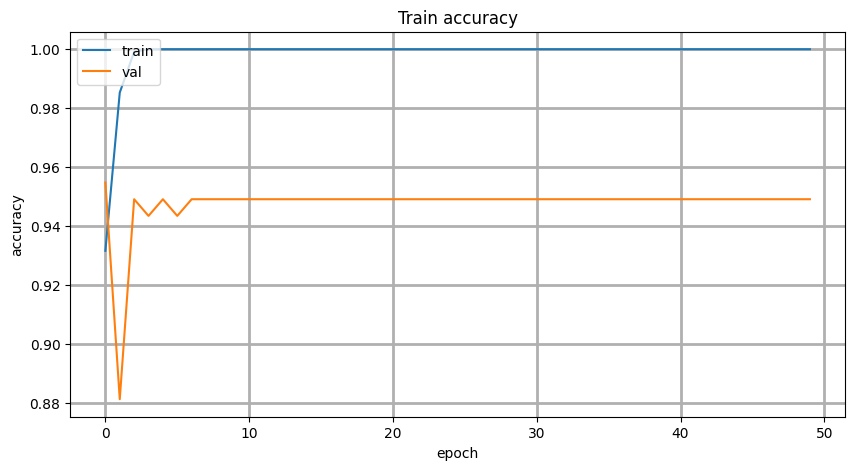

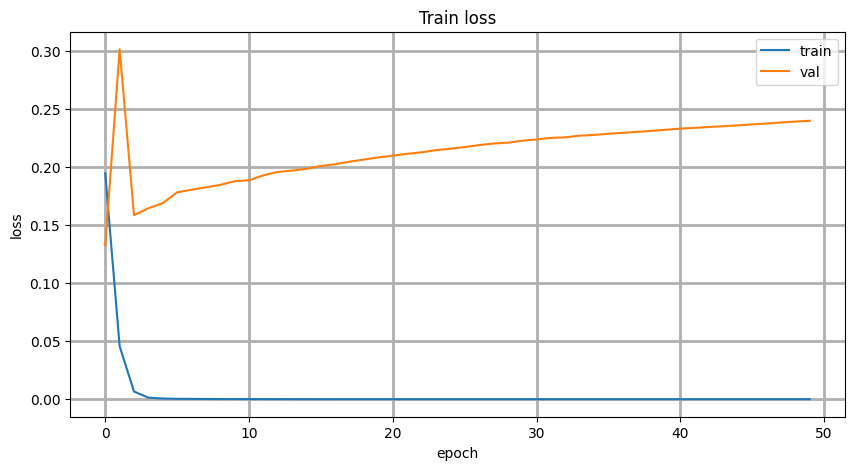

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - acc: 0.9654 - loss: 0.0548


[0.0604453980922699, 0.9661017060279846]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_2.h5')

###Round 2

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.7013 - loss: 0.6532


[0.672563910484314, 0.6779661178588867]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - acc: 0.8234 - loss: 0.4216 - val_acc: 0.9379 - val_loss: 0.1334
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - acc: 0.9470 - loss: 0.1335 - val_acc: 0.9435 - val_loss: 0.1399
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - acc: 0.9976 - loss: 0.0117 - val_acc: 0.9435 - val_loss: 0.1463
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - acc: 0.9988 - loss: 0.0064 - val_acc: 0.9605 - val_loss: 0.1163
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - acc: 1.0000 - loss: 0.0017 - val_acc: 0.9492 - val_loss: 0.1337
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - acc: 1.0000 - loss: 6.3296e-04 - val_acc: 0.9492 - val_loss: 0.1326
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - acc: 1.0000 - loss: 4.3402e-04 - val_acc: 0.9492 - val_loss: 0.1378
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 1.0000 - loss: 3.1287e-04 - val_acc: 0.9492 - val_loss: 0.1406
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━

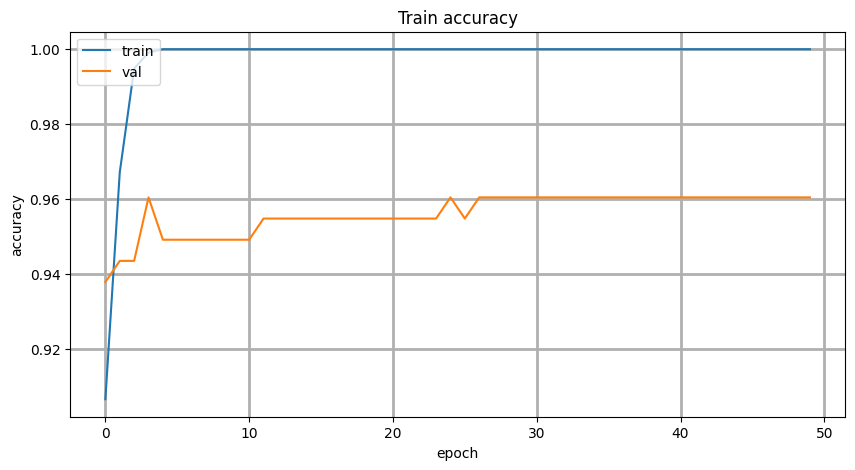

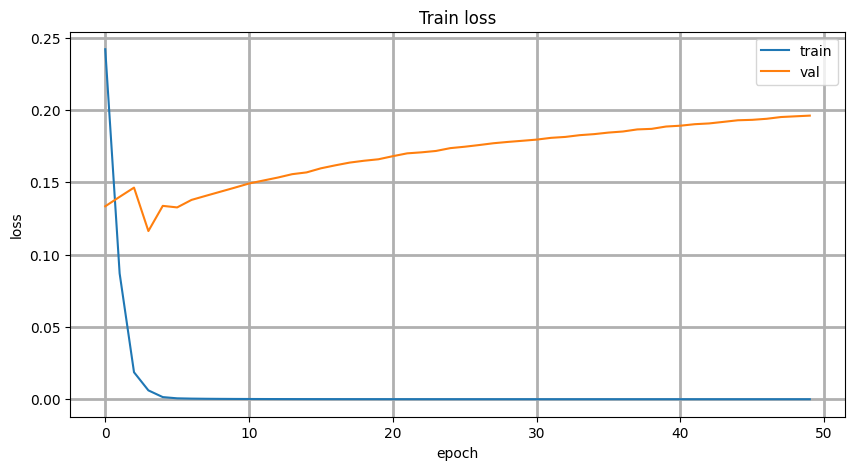

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - acc: 0.9791 - loss: 0.0563


[0.08383762836456299, 0.9661017060279846]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_2.h5')

###Round 3

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.3577 - loss: 0.8398


[0.8344424962997437, 0.3502824902534485]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - acc: 0.7901 - loss: 0.4354 - val_acc: 0.9096 - val_loss: 0.2134
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - acc: 0.9882 - loss: 0.0423 - val_acc: 0.9040 - val_loss: 0.2159
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - acc: 0.9984 - loss: 0.0188 - val_acc: 0.9605 - val_loss: 0.1393
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - acc: 1.0000 - loss: 0.0069 - val_acc: 0.9548 - val_loss: 0.1429
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - acc: 0.9993 - loss: 0.0017 - val_acc: 0.9322 - val_loss: 0.2350
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 1.0000 - loss: 9.3821e-04 - val_acc: 0.9379 - val_loss: 0.2117
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 1.0000 - loss: 2.6634e-04 - val_acc: 0.9435 - val_loss: 0.1999
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 1.0000 - loss: 1.4879e-04 - val_acc: 0.9435 - val_loss: 0.1975
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━

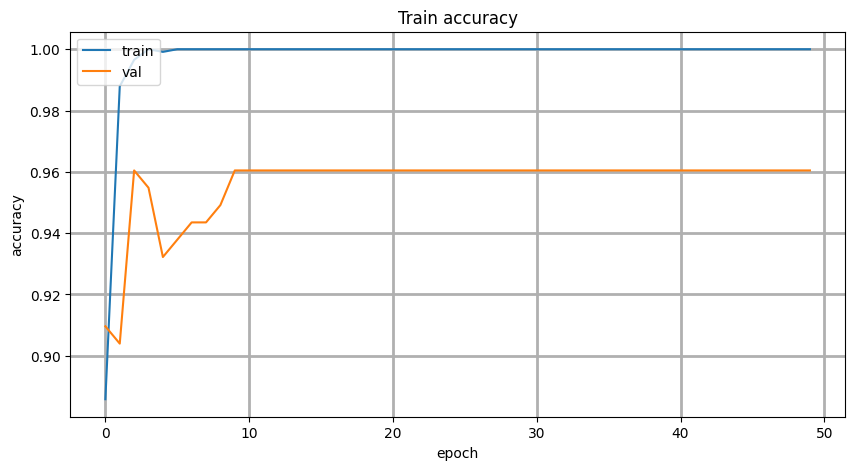

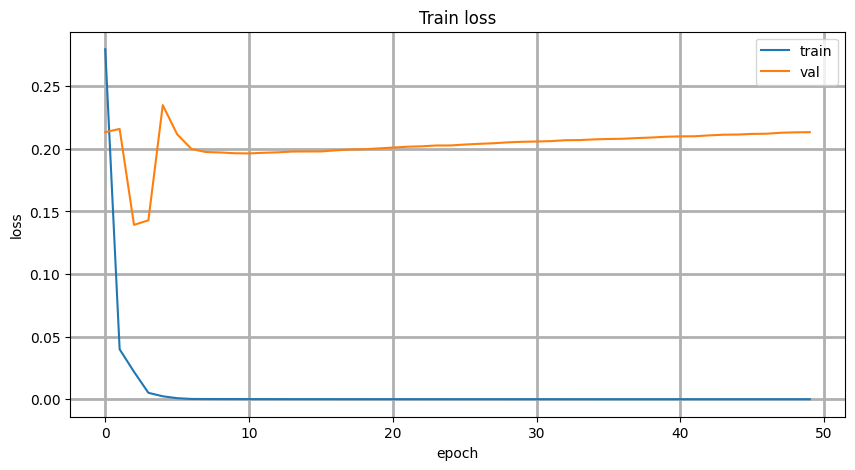

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - acc: 0.9948 - loss: 0.0197


[0.02808215469121933, 0.9887005686759949]

In [ ]:
#save model4
model4.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_2.h5')

##Add dense 512 & 256 with BatchNorm to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.5234 - loss: 0.6951


[0.7005030512809753, 0.5310734510421753]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 537ms/step - acc: 0.8721 - loss: 0.3167 - val_acc: 0.9153 - val_loss: 0.2698
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - acc: 0.9952 - loss: 0.0306 - val_acc: 0.9266 - val_loss: 0.2000
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 339ms/step - acc: 0.9931 - loss: 0.0275 - val_acc: 0.9266 - val_loss: 0.1989
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - acc: 0.9997 - loss: 0.0071 - val_acc: 0.9492 - val_loss: 0.1535
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.9984 - loss: 0.0084 - val_acc: 0.9605 - val_loss: 0.1284
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 1.0000 - loss: 0.0070 - val_acc: 0.9605 - val_loss: 0.0891
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 0.9932 - loss: 0.0230 - val_acc: 0.9492 - val_loss: 0.1339
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - acc: 0.9924 - loss: 0.0250 - val_acc: 0.9266 - val_loss: 0.2193
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/

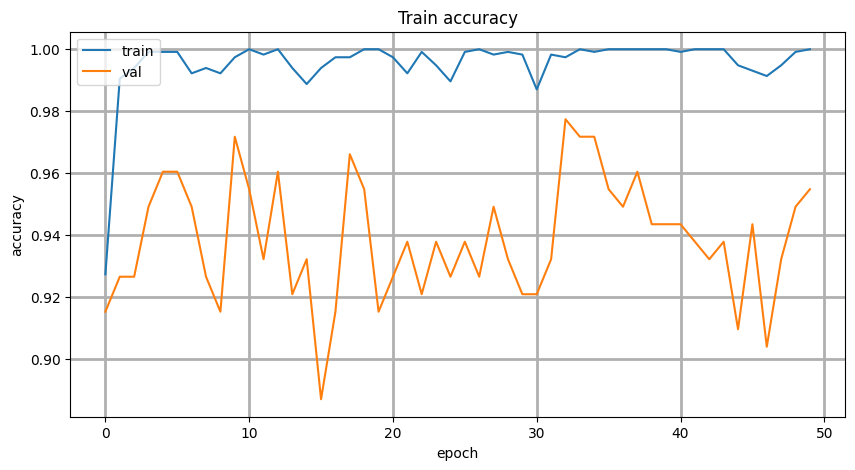

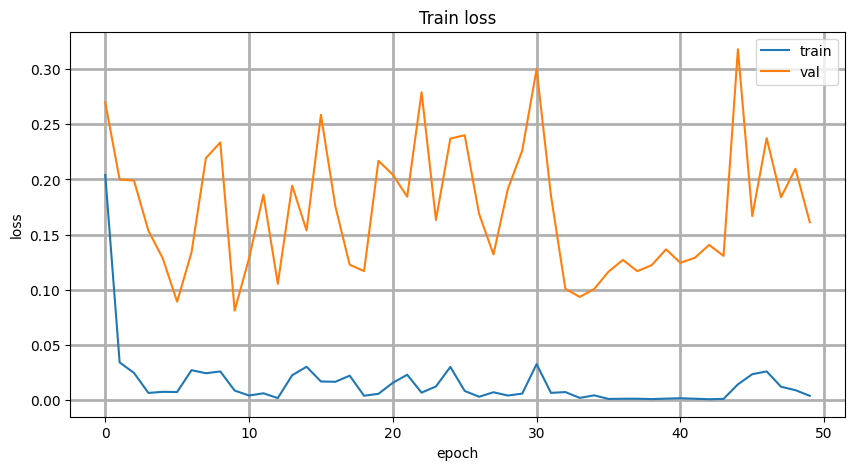

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - acc: 0.9517 - loss: 0.1085


[0.1181533932685852, 0.9548022747039795]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_3.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.5136 - loss: 0.7749


[0.7590233683586121, 0.5367231369018555]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 521ms/step - acc: 0.8735 - loss: 0.3072 - val_acc: 0.8927 - val_loss: 0.2426
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - acc: 0.9897 - loss: 0.0335 - val_acc: 0.9209 - val_loss: 0.2303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 339ms/step - acc: 0.9996 - loss: 0.0111 - val_acc: 0.9379 - val_loss: 0.1571
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step - acc: 1.0000 - loss: 0.0050 - val_acc: 0.9492 - val_loss: 0.1232
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.9993 - loss: 0.0056 - val_acc: 0.9266 - val_loss: 0.1868
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 1.0000 - loss: 0.0023 - val_acc: 0.9379 - val_loss: 0.1663
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 1.0000 - loss: 0.0016 - val_acc: 0.9266 - val_loss: 0.1836
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - acc: 1.0000 - loss: 0.0036 - val_acc: 0.9548 - val_loss: 0.1404
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/

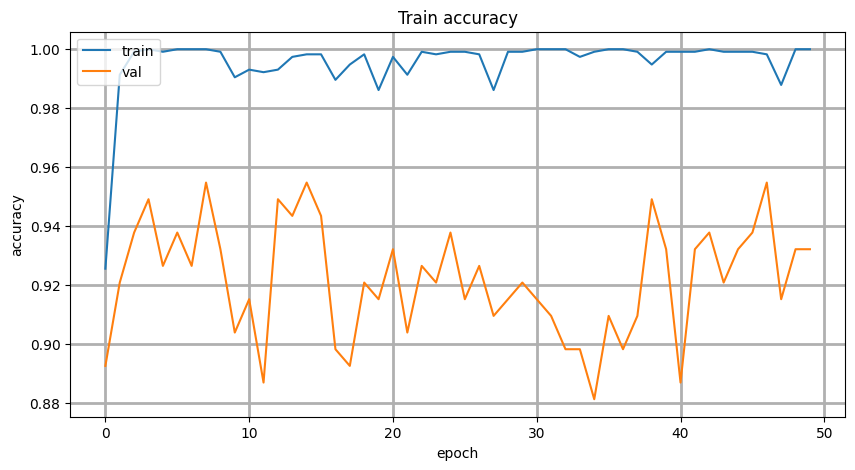

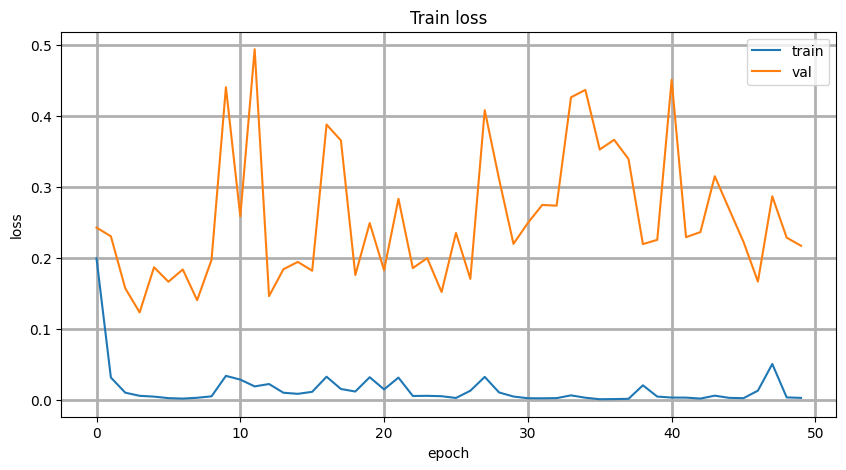

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - acc: 0.9532 - loss: 0.1666


[0.17071273922920227, 0.9435028433799744]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_3.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_4 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.3356 - loss: 0.7974


[0.7936267852783203, 0.3502824902534485]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 527ms/step - acc: 0.8329 - loss: 0.3671 - val_acc: 0.9209 - val_loss: 0.2126
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - acc: 0.9939 - loss: 0.0323 - val_acc: 0.9153 - val_loss: 0.2094
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - acc: 0.9974 - loss: 0.0154 - val_acc: 0.8757 - val_loss: 0.2895
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 339ms/step - acc: 0.9998 - loss: 0.0104 - val_acc: 0.9322 - val_loss: 0.2221
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - acc: 0.9963 - loss: 0.0110 - val_acc: 0.9492 - val_loss: 0.1234
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9929 - loss: 0.0222 - val_acc: 0.9435 - val_loss: 0.1838
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - acc: 0.9937 - loss: 0.0144 - val_acc: 0.9435 - val_loss: 0.1586
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 1.0000 - loss: 0.0049 - val_acc: 0.9548 - val_loss: 0.0988
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/

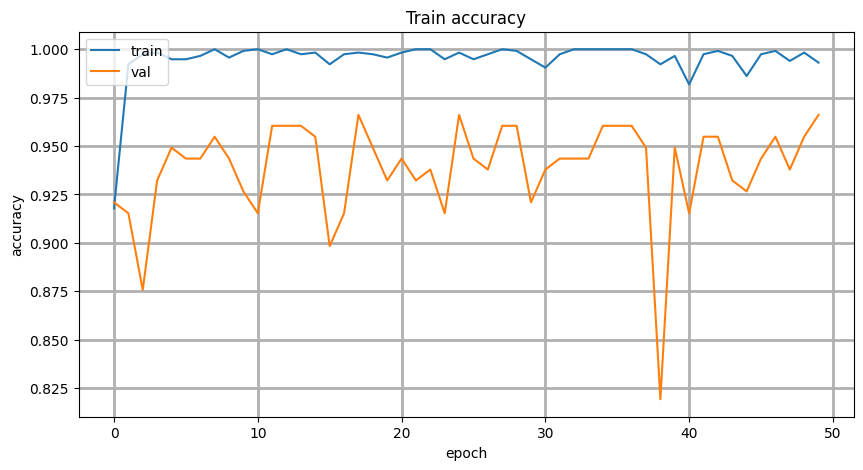

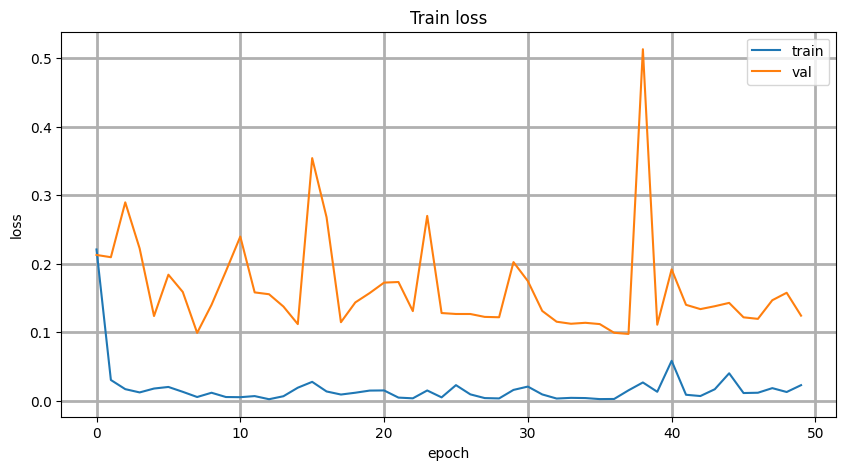

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - acc: 0.9386 - loss: 0.1396


[0.13029366731643677, 0.9435028433799744]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_3.h5')

##Add dense 512 & 256 with dropout 0.5 to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_6 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.4077 - loss: 0.7898


[0.7919362187385559, 0.40112993121147156]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 570ms/step - acc: 0.7068 - loss: 0.5876 - val_acc: 0.8870 - val_loss: 0.2478
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - acc: 0.9591 - loss: 0.1240 - val_acc: 0.9266 - val_loss: 0.1618
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - acc: 0.9672 - loss: 0.0910 - val_acc: 0.9322 - val_loss: 0.1813
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - acc: 0.9791 - loss: 0.0519 - val_acc: 0.9379 - val_loss: 0.1305
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.9924 - loss: 0.0258 - val_acc: 0.9548 - val_loss: 0.1318
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9945 - loss: 0.0157 - val_acc: 0.9209 - val_loss: 0.2070
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - acc: 0.9919 - loss: 0.0189 - val_acc: 0.9379 - val_loss: 0.1833
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9921 - loss: 0.0179 - val_acc: 0.9322 - val_loss: 0.1804
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/

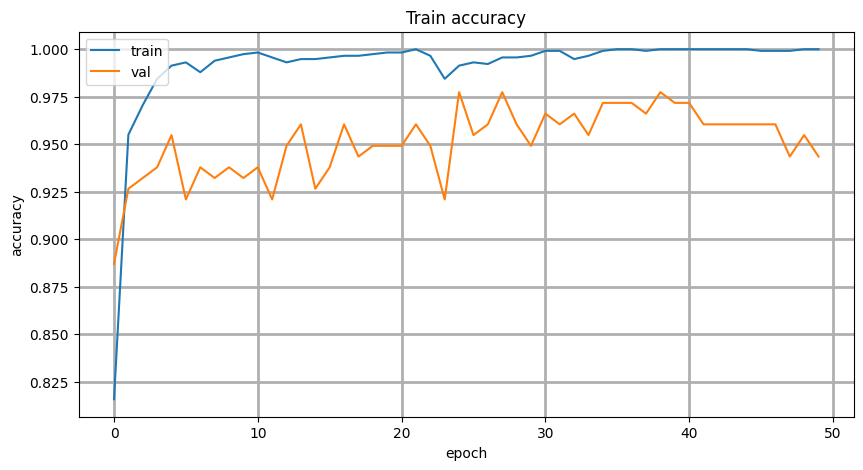

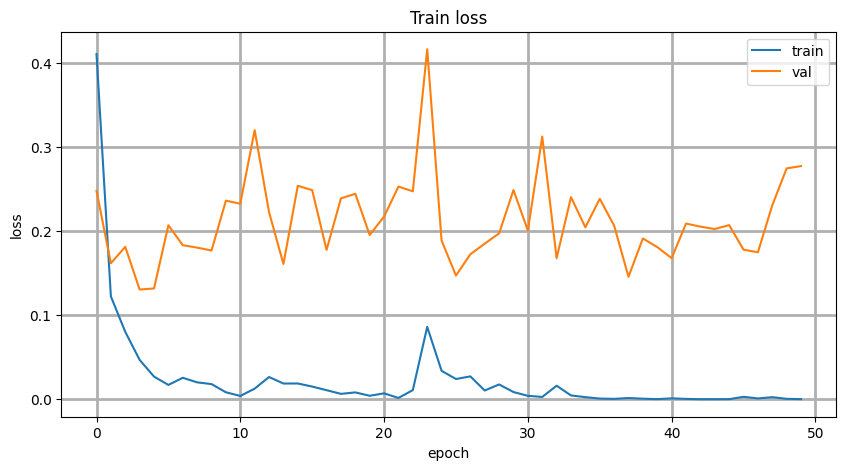

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - acc: 0.9726 - loss: 0.1024


[0.09769490361213684, 0.9661017060279846]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_7 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.7157 - loss: 0.6548


[0.6686096787452698, 0.6892655491828918]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 548ms/step - acc: 0.7787 - loss: 0.5466 - val_acc: 0.8983 - val_loss: 0.1945
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - acc: 0.9515 - loss: 0.1475 - val_acc: 0.9322 - val_loss: 0.1603
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - acc: 0.9821 - loss: 0.0592 - val_acc: 0.9492 - val_loss: 0.1444
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - acc: 0.9880 - loss: 0.0410 - val_acc: 0.9435 - val_loss: 0.1737
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - acc: 0.9939 - loss: 0.0332 - val_acc: 0.9266 - val_loss: 0.2444
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9840 - loss: 0.0334 - val_acc: 0.9322 - val_loss: 0.2004
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - acc: 0.9918 - loss: 0.0252 - val_acc: 0.9379 - val_loss: 0.2291
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 0.9965 - loss: 0.0142 - val_acc: 0.9435 - val_loss: 0.1860
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/

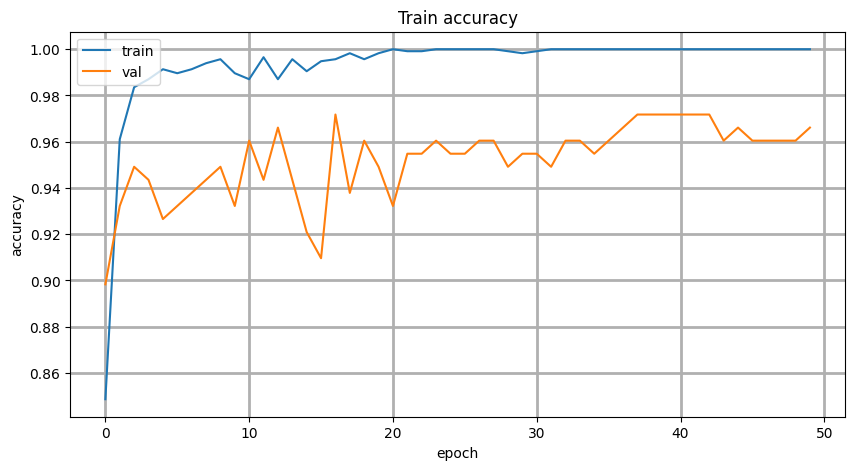

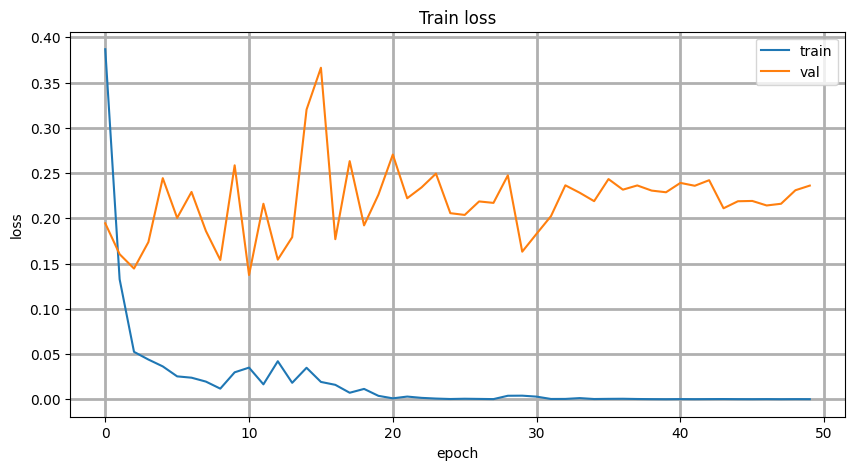

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - acc: 0.9828 - loss: 0.0554


[0.07715239375829697, 0.9661017060279846]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_9 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#import tensorflow as tf

# Force eager execution to avoid the error
#tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.3602 - loss: 0.7822


[0.7810153365135193, 0.38983049988746643]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 564ms/step - acc: 0.7018 - loss: 0.6011 - val_acc: 0.9096 - val_loss: 0.2063
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step - acc: 0.9428 - loss: 0.1542 - val_acc: 0.9153 - val_loss: 0.2050
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - acc: 0.9661 - loss: 0.0957 - val_acc: 0.9435 - val_loss: 0.1437
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.9869 - loss: 0.0366 - val_acc: 0.9435 - val_loss: 0.1320
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9930 - loss: 0.0204 - val_acc: 0.9435 - val_loss: 0.1691
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 0.9922 - loss: 0.0226 - val_acc: 0.9548 - val_loss: 0.1552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - acc: 0.9923 - loss: 0.0139 - val_acc: 0.9548 - val_loss: 0.1350
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - acc: 0.9997 - loss: 0.0044 - val_acc: 0.9492 - val_loss: 0.1522
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/

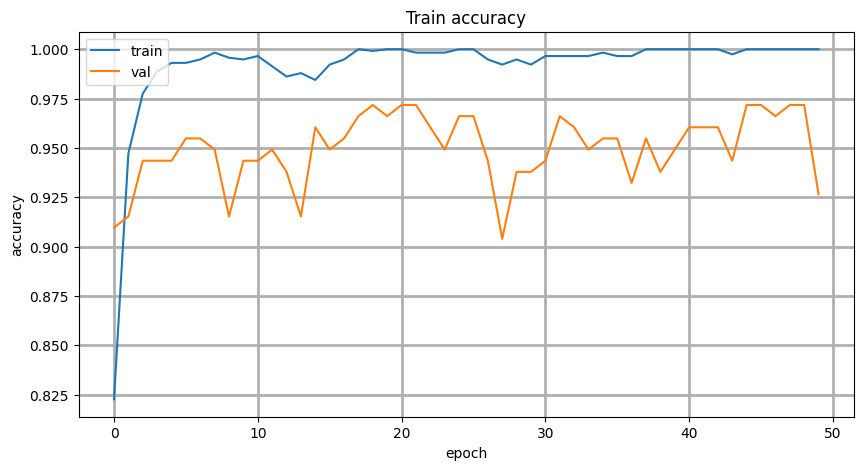

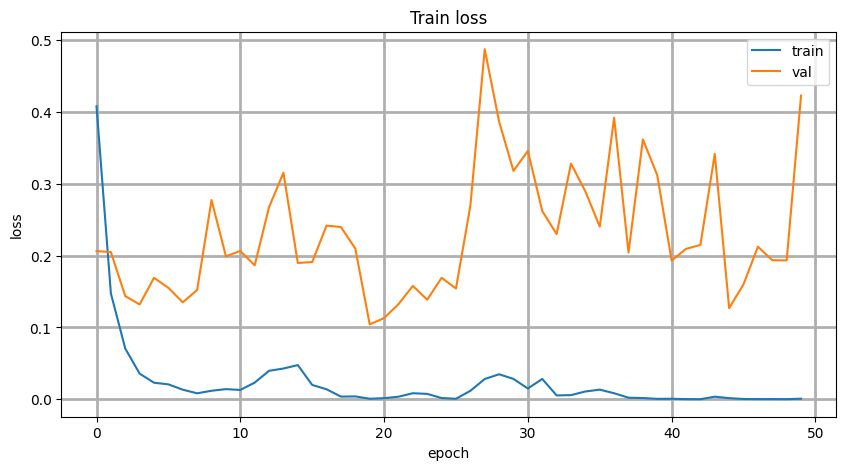

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - acc: 0.9481 - loss: 0.2746


[0.3144361078739166, 0.9378530979156494]

In [ ]:
#save model6
model6.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_1.h5')

##Add dense 512 & 256 with dropout 0.25 to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.3821 - loss: 0.7835


[0.776418924331665, 0.40112993121147156]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 524ms/step - acc: 0.7610 - loss: 0.4962 - val_acc: 0.8701 - val_loss: 0.2613
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - acc: 0.9659 - loss: 0.0953 - val_acc: 0.9548 - val_loss: 0.1213
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - acc: 0.9748 - loss: 0.0678 - val_acc: 0.9661 - val_loss: 0.0802
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - acc: 0.9975 - loss: 0.0128 - val_acc: 0.9605 - val_loss: 0.0940
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - acc: 1.0000 - loss: 0.0059 - val_acc: 0.9548 - val_loss: 0.1228
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - acc: 1.0000 - loss: 0.0018 - val_acc: 0.9492 - val_loss: 0.1614
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - acc: 1.0000 - loss: 6.7206e-04 - val_acc: 0.9548 - val_loss: 0.1584
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - acc: 1.0000 - loss: 6.8287e-04 - val_acc: 0.9492 - val_loss: 0.1423
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12

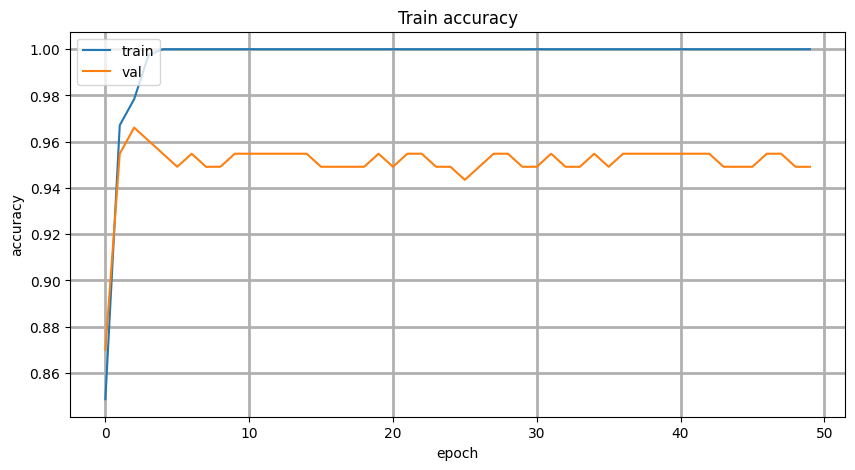

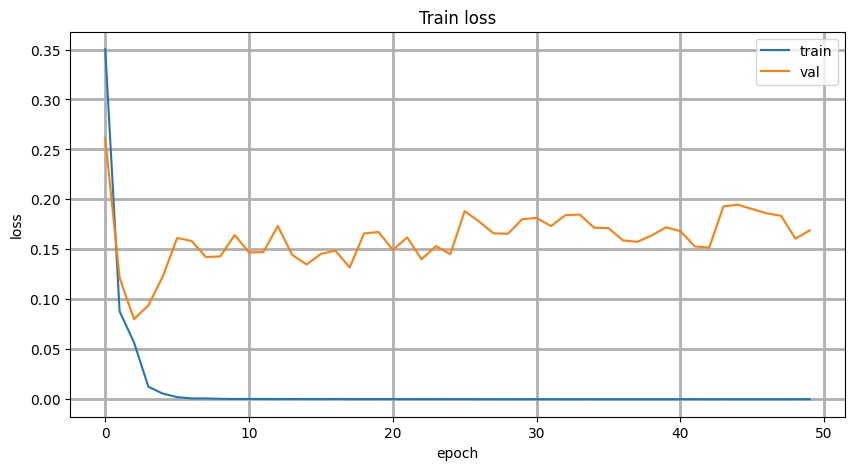

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - acc: 0.9658 - loss: 0.1761


[0.15321063995361328, 0.9661017060279846]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.3158 - loss: 0.9765


[0.9767407774925232, 0.3050847351551056]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 531ms/step - acc: 0.7451 - loss: 0.5233 - val_acc: 0.9379 - val_loss: 0.1711
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - acc: 0.9416 - loss: 0.1356 - val_acc: 0.9492 - val_loss: 0.1157
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - acc: 0.9959 - loss: 0.0315 - val_acc: 0.9718 - val_loss: 0.0854
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9972 - loss: 0.0113 - val_acc: 0.9718 - val_loss: 0.0895
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - acc: 0.9949 - loss: 0.0135 - val_acc: 0.9492 - val_loss: 0.1132
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - acc: 1.0000 - loss: 0.0038 - val_acc: 0.9492 - val_loss: 0.1215
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - acc: 1.0000 - loss: 0.0021 - val_acc: 0.9605 - val_loss: 0.1142
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - acc: 1.0000 - loss: 7.7523e-04 - val_acc: 0.9492 - val_loss: 0.1530
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 32

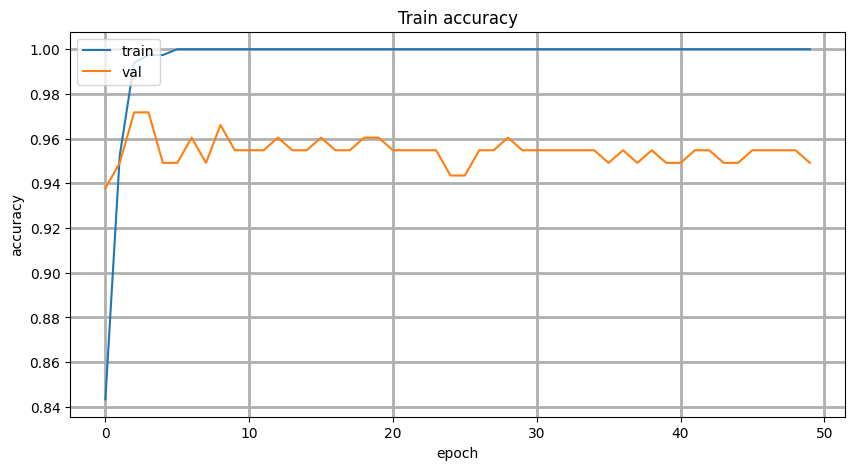

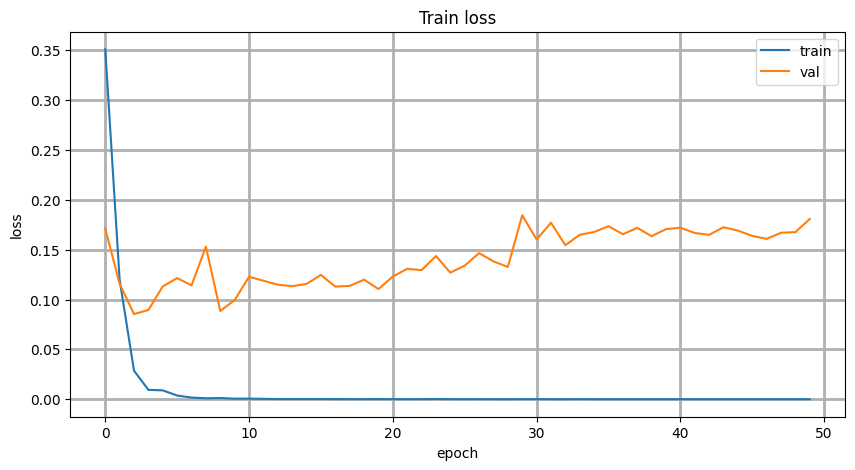

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - acc: 0.9658 - loss: 0.1285


[0.1163017600774765, 0.9661017060279846]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_3 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,642 (2.50 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.3077 - loss: 0.9552


[0.9372878670692444, 0.29378530383110046]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 526ms/step - acc: 0.7744 - loss: 0.4812 - val_acc: 0.9379 - val_loss: 0.1495
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - acc: 0.9681 - loss: 0.0931 - val_acc: 0.9718 - val_loss: 0.0879
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9929 - loss: 0.0291 - val_acc: 0.9605 - val_loss: 0.1117
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9987 - loss: 0.0076 - val_acc: 0.9435 - val_loss: 0.1823
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - acc: 0.9938 - loss: 0.0262 - val_acc: 0.9548 - val_loss: 0.1220
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - acc: 0.9934 - loss: 0.0239 - val_acc: 0.9605 - val_loss: 0.1096
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - acc: 0.9976 - loss: 0.0062 - val_acc: 0.9718 - val_loss: 0.0491
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 0.9983 - loss: 0.0062 - val_acc: 0.9266 - val_loss: 0.2121
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/

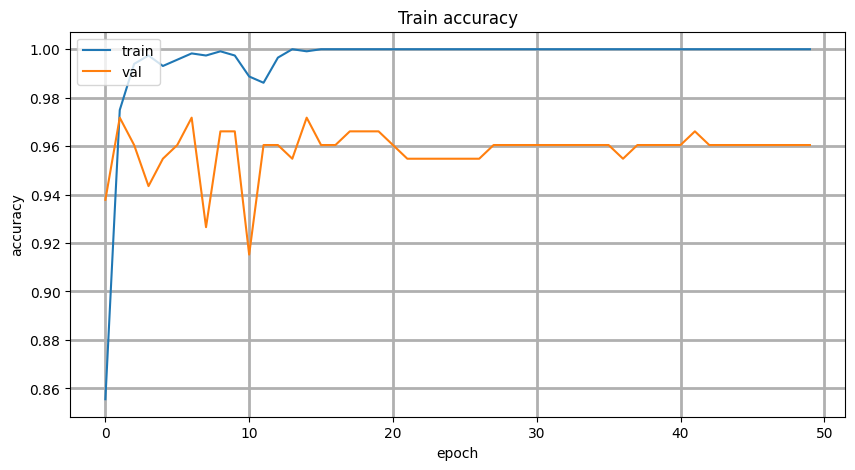

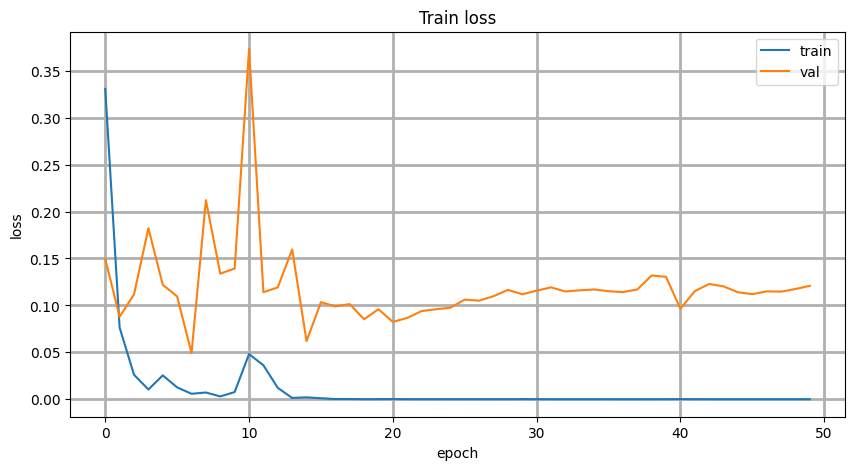

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - acc: 0.9641 - loss: 0.1913


[0.1759079247713089, 0.9604519605636597]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

##Add dense 512 & 256 with dropout 0.25 with BatchNorm to model

###Round 1


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_7 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.2980 - loss: 0.8900


[0.9019083976745605, 0.2711864411830902]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 532ms/step - acc: 0.7983 - loss: 0.4676 - val_acc: 0.9040 - val_loss: 0.2149
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - acc: 0.9797 - loss: 0.0761 - val_acc: 0.9492 - val_loss: 0.1178
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - acc: 0.9959 - loss: 0.0336 - val_acc: 0.9605 - val_loss: 0.0998
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9983 - loss: 0.0193 - val_acc: 0.9661 - val_loss: 0.0984
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - acc: 0.9899 - loss: 0.0318 - val_acc: 0.9492 - val_loss: 0.1274
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - acc: 0.9956 - loss: 0.0225 - val_acc: 0.9435 - val_loss: 0.1139
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - acc: 0.9931 - loss: 0.0204 - val_acc: 0.9661 - val_loss: 0.0931
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 1.0000 - loss: 0.0077 - val_acc: 0.9718 - val_loss: 0.0890
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/

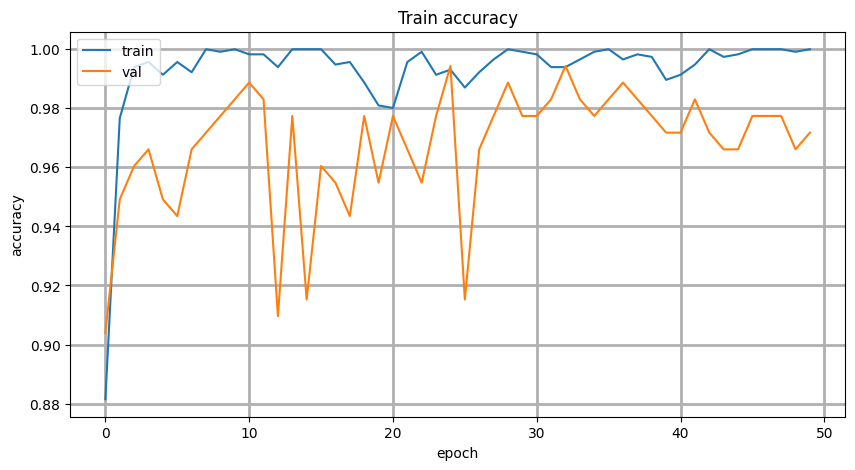

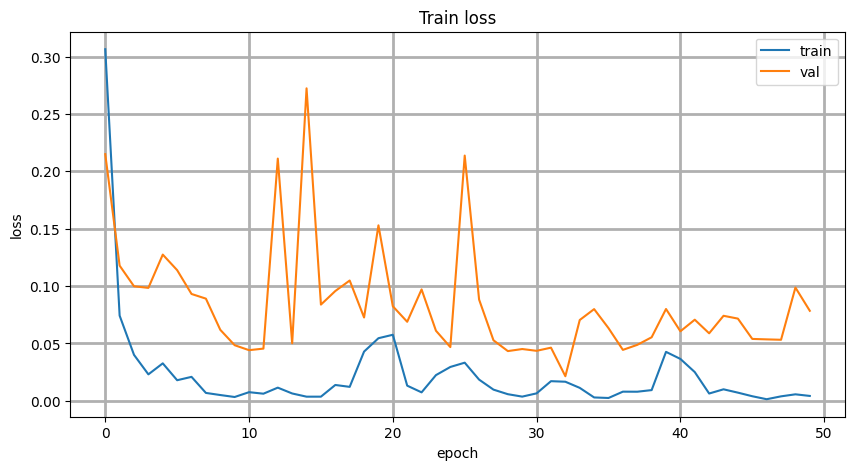

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - acc: 0.9632 - loss: 0.0710


[0.06666209548711777, 0.9661017060279846]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')

###Round 2


In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_8 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.3363 - loss: 0.8706


[0.8634110689163208, 0.3446327745914459]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 538ms/step - acc: 0.8244 - loss: 0.4358 - val_acc: 0.8644 - val_loss: 0.3054
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - acc: 0.9801 - loss: 0.0651 - val_acc: 0.9492 - val_loss: 0.1347
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9935 - loss: 0.0250 - val_acc: 0.8814 - val_loss: 0.2732
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - acc: 0.9998 - loss: 0.0145 - val_acc: 0.9492 - val_loss: 0.0973
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - acc: 0.9988 - loss: 0.0084 - val_acc: 0.9548 - val_loss: 0.0939
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - acc: 0.9982 - loss: 0.0100 - val_acc: 0.9605 - val_loss: 0.0834
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - acc: 0.9990 - loss: 0.0056 - val_acc: 0.9322 - val_loss: 0.1302
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - acc: 0.9913 - loss: 0.0337 - val_acc: 0.9548 - val_loss: 0.1162
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/

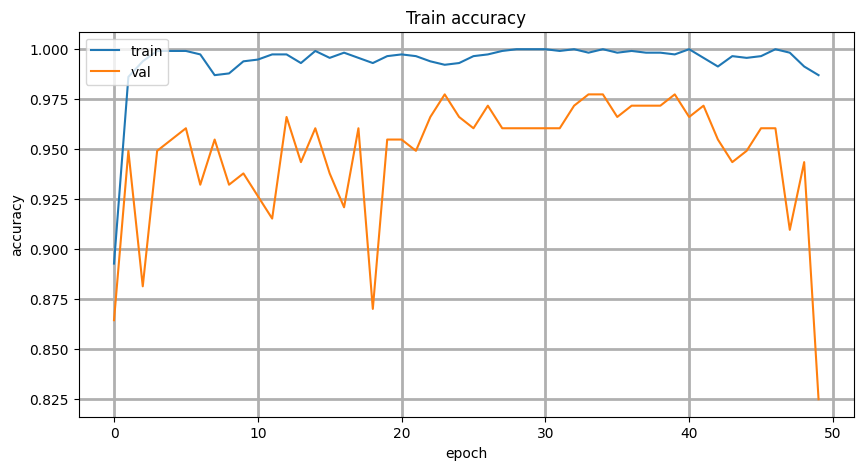

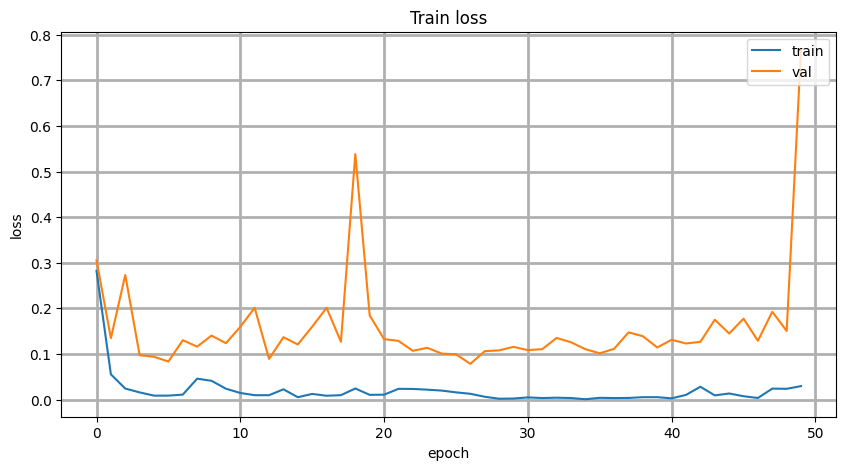

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - acc: 0.9134 - loss: 0.3520


[0.4108043611049652, 0.8926553726196289]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_9 (GetItem)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,714 (2.52 MB)

 Trainable params: 658,178 (2.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.6806 - loss: 0.6404


[0.6333600282669067, 0.6892655491828918]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 547ms/step - acc: 0.7974 - loss: 0.4700 - val_acc: 0.8475 - val_loss: 0.3181
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9818 - loss: 0.0725 - val_acc: 0.8757 - val_loss: 0.2560
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9920 - loss: 0.0313 - val_acc: 0.8757 - val_loss: 0.2881
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - acc: 0.9929 - loss: 0.0293 - val_acc: 0.8927 - val_loss: 0.2663
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - acc: 0.9972 - loss: 0.0143 - val_acc: 0.9661 - val_loss: 0.1165
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - acc: 0.9933 - loss: 0.0204 - val_acc: 0.8870 - val_loss: 0.2816
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - acc: 0.9993 - loss: 0.0187 - val_acc: 0.9548 - val_loss: 0.1102
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - acc: 1.0000 - loss: 0.0074 - val_acc: 0.9718 - val_loss: 0.0669
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/

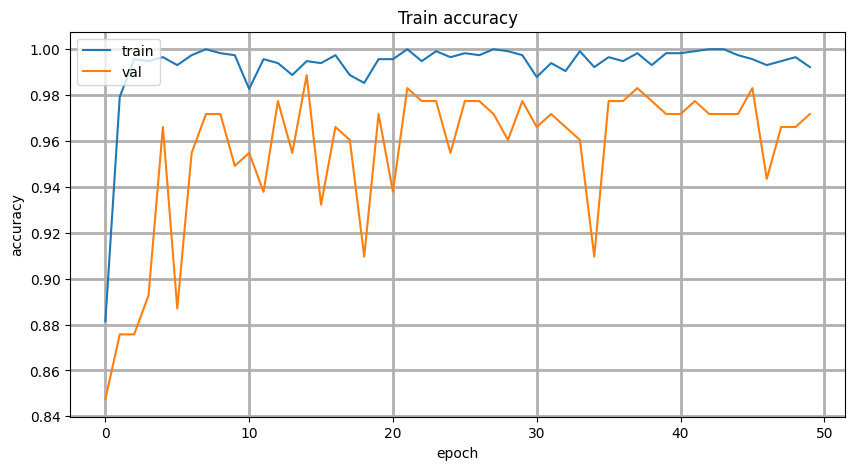

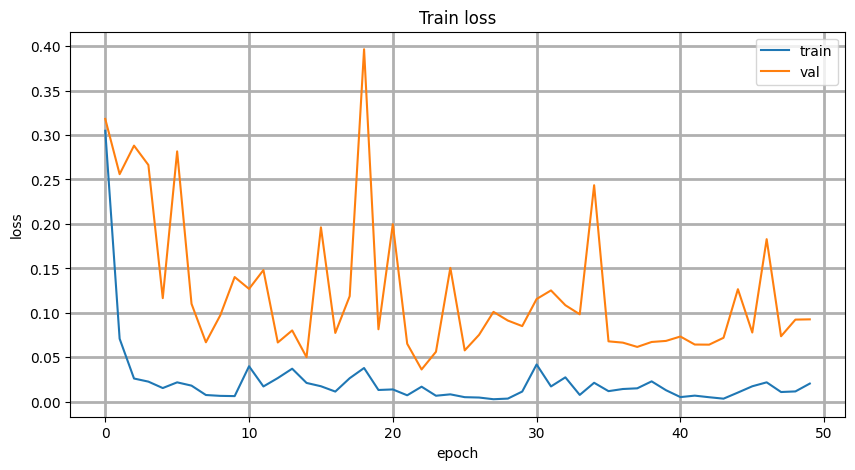

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - acc: 0.9570 - loss: 0.1576


[0.14164109528064728, 0.9548022747039795]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')